(360, 360) (9, 362, 362)


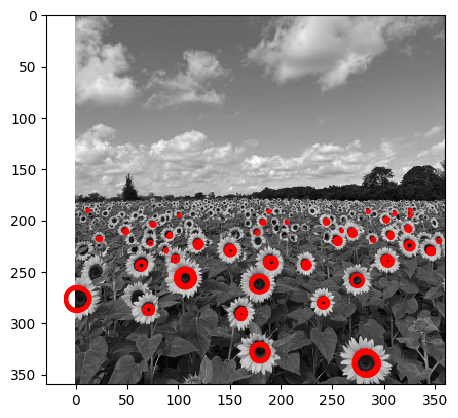

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read image
img = cv2.imread("the_berry_farms_sunflower_field.jpeg", cv2.IMREAD_REDUCED_COLOR_4)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = img.astype(np.float32) / 255.0 #normalizing

k = 1.414
sigma = 1.0


def LoG(sigma):
    #window size 
    hw = 3*sigma 
    # creating meshgrid
    X, Y = np.meshgrid(np.arange(-hw, hw + 1, 1), np.arange(-hw, hw + 1, 1))
    # LoG filter
    log = 1/(2*np.pi*sigma**2)*(X**2/(sigma**2) + Y**2/(sigma**2) - 2)*np.exp(-(X**2 + Y**2)/(2*sigma**2))
    return log



def LoG_convolve(img):
    log_images = [] #to store responses
    for sigma in range(1,10):
       
        filter_log = LoG(sigma) #filter generation
        image = cv2.filter2D(img,-1,filter_log) # convolving image

        image = np.pad(image,((1,1),(1,1)),'constant') 
        image = np.square(image) 
        log_images.append(image)
    log_image_np = np.array([i for i in log_images]) # converting to numpy array
    return log_image_np
log_image_np = LoG_convolve(img)


def detect_blob(log_image_np):
    co_ordinates = [] #to store co ordinates
    (h,w) = img.shape #image size
    print(img.shape,log_image_np.shape)
    # finding maximum in  window
    for i in range(1,h):
        for j in range(1,w):
            
            slice_img = log_image_np[:,i-1:i+2,j-1:j+2] 
            result = np.amax(slice_img) #finding maximum
            if result >= 0.1: #threshold
                # finding co-ordinates of maximum; x: row, y: column, z: depth
                z,x,y = np.unravel_index(slice_img.argmax(),slice_img.shape)
                # storing co-ordinates
                co_ordinates.append((i+x-1,j+y-1,k**z*sigma)) # storing co-ordinates: (x,y,radius)
    return co_ordinates
co_ordinates = list(set(detect_blob(log_image_np)))

fig, ax = plt.subplots()
nh,nw = img.shape
count = 0

ax.imshow(img, interpolation='nearest',cmap="gray")
for blob in co_ordinates:
    y,x,r = blob
    c = plt.Circle((x, y), r*1.414, color='red', linewidth=1.5, fill=False)
    ax.add_patch(c)
ax.plot()  
plt.show()

(50,)


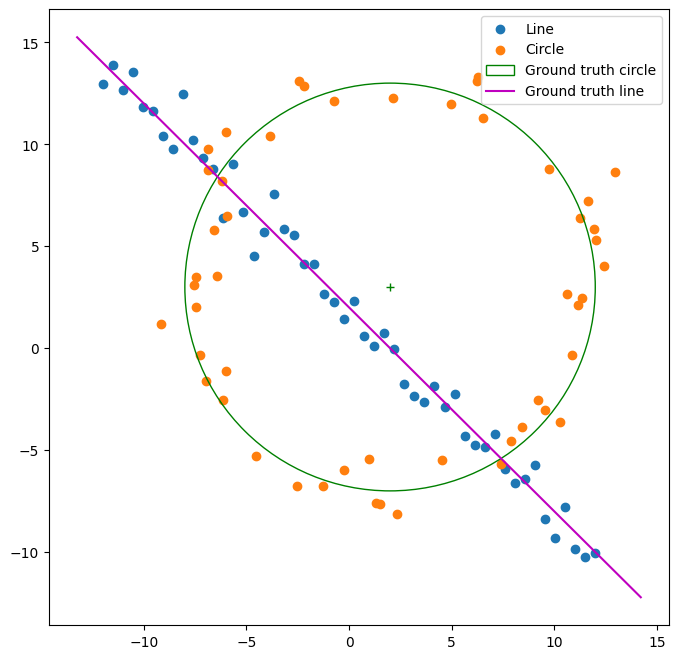

In [44]:
# Generation of a Noisy Point Set Conforming to a Line and a Ci r cl e
import numpy as np
from scipy . optimize import minimize
from scipy import linalg
import matplotlib . pyplot as plt
import tikzplotlib
# np . random . seed ( 0)
N = 100
half_n = N// 2
r = 10
x0_gt , y0_gt = 2 , 3 # Center
s = r /16
t = np . random . uniform (0 , 2*np . pi , half_n ) 
n = s*np . random . randn ( half_n )
x , y = x0_gt + ( r + n)*np . cos ( t ) , y0_gt + ( r + n)*np . sin ( t )
X_circ = np . hstack ( ( x . reshape ( half_n , 1 ) , y . reshape ( half_n , 1 ) ) )
s = 1.
m, b = -1, 2
x = np . linspace (-12, 12 , half_n )
print(x.shape)
y = m*x + b + s*np . random . randn ( half_n )
X_line = np . hstack ( ( x . reshape ( half_n , 1 ) , y . reshape ( half_n , 1 ) ) )
X = np . vstack ( ( X_circ , X_line ) ) # All point s
fig , ax = plt . subplots (1 ,1 , figsize =(8 ,8))
ax . scatter ( X_line [ : , 0 ] , X_line [ : , 1 ] , label= 'Line' )
ax . scatter ( X_circ [ : , 0 ] , X_circ [ : , 1 ] , label= 'Circle' )
circle_gt = plt . Circle ( ( x0_gt , y0_gt ) , r , color= 'g' , fill =False , label= 'Ground truth circle' )
ax . add_patch ( circle_gt )
ax . plot ( ( x0_gt ) , ( y0_gt ) , '+' , color= 'g' )
x_min , x_max = ax . get_xlim ( )
x_g = np . array ( [ x_min , x_max ] )
y_g = m*x_g + b
plt . plot ( x_g , y_g , color= 'm' , label= 'Ground truth line' )
plt . legend ( )

New best model found with 35 inliers
New best model found with 46 inliers
New best model found with 50 inliers
New best model found with 51 inliers


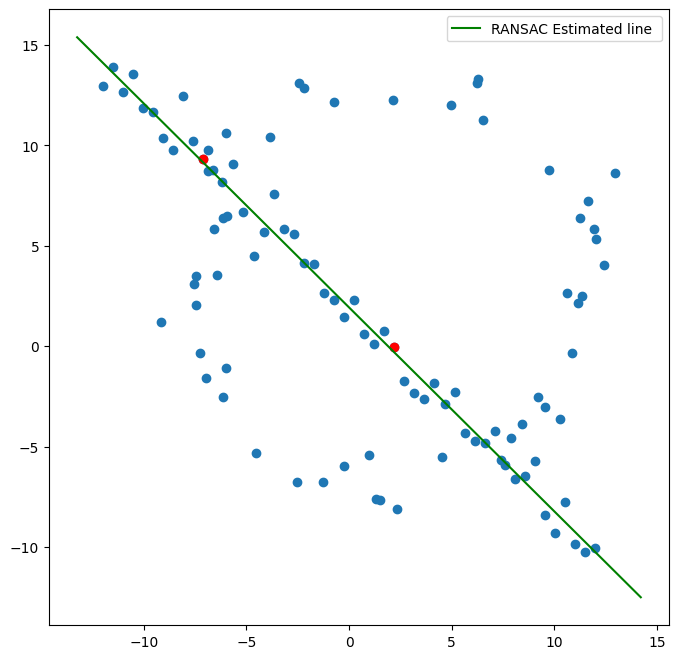

In [45]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have your data points in a variable X as an Nx2 numpy array

# Parameters
s = 2
t = 1
d = 20
k = 100000
N = X.shape[0]

# Initialize variables to store the best model
best_model = None
max_inlier_count = 0
best_inliers_L = None
S1, S2 = None, None

for i in range(k):
    # Select s points at random
    indices = np.random.choice(N, s, replace=False)
    s1 = X[indices[0]]
    s2 = X[indices[1]]

    # Fit the model using Total Least Squares: ax + bx = c
    a = s2[1] - s1[1]
    b = s1[0] - s2[0]
    c = s1[0] * (a / b) + s1[1]
    c = c * b

    # Compute the unit normal [a, b]^T
    norm = np.sqrt(a ** 2 + b ** 2)
    a /= norm
    b /= norm
    c /= norm

    # Compute the distances between all points and the model
    distances = np.abs(a * X[:, 0] + b * X[:, 1] - c)

    # Compute the inliers count
    inlier_count = np.sum(distances < t)

    # Check if the current set of inliers is the best one
    if inlier_count > max_inlier_count and inlier_count > d:
        print("New best model found with {} inliers".format(inlier_count))
        max_inlier_count = inlier_count
        best_model = (a, b, c)
        best_inliers_L = X[distances < t]
        S1 = s1
        S2 = s2

# Retrieve the best model
a, b, c = best_model

# Find the best model using best_inliers with TLS
def tls_fit(points):
    # Calculate the centroid of the inliers
    centroid = np.mean(points, axis=0)

    # Center the data by subtracting the centroid
    centered_points = points - centroid

    # Compute the covariance matrix
    cov_matrix = np.dot(centered_points.T, centered_points)

    # Compute the eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

    # Find the smallest eigenvalue and corresponding eigenvector
    min_eigenvalue_index = np.argmin(eigenvalues)
    min_eigenvalue = eigenvalues[min_eigenvalue_index]
    min_eigenvector = eigenvectors[:, min_eigenvalue_index]

    # Compute the normal vector of the line (a, b)
    a, b = -min_eigenvector / np.linalg.norm(min_eigenvector)

    # Compute the c parameter of the line (ax + by = c)
    c = a * centroid[0] + b * centroid[1]

    return a, b, c

# Fit the best model using TLS on best_inliers
tls_a, tls_b, tls_c = tls_fit(best_inliers_L)

# Display the results
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Plot the points
ax.scatter(X[:, 0], X[:, 1])

# Plot the best s1 and s2 points
ax.plot(S1[0], S1[1], 'ro')
ax.plot(S2[0], S2[1], 'ro')



# Plot the estimated line obtained by TLS
y_tls = (tls_c - tls_a * x_g) / tls_b
plt.plot(x_g, y_tls, color='g', label='RANSAC Estimated line ')

plt.legend()
plt.show()


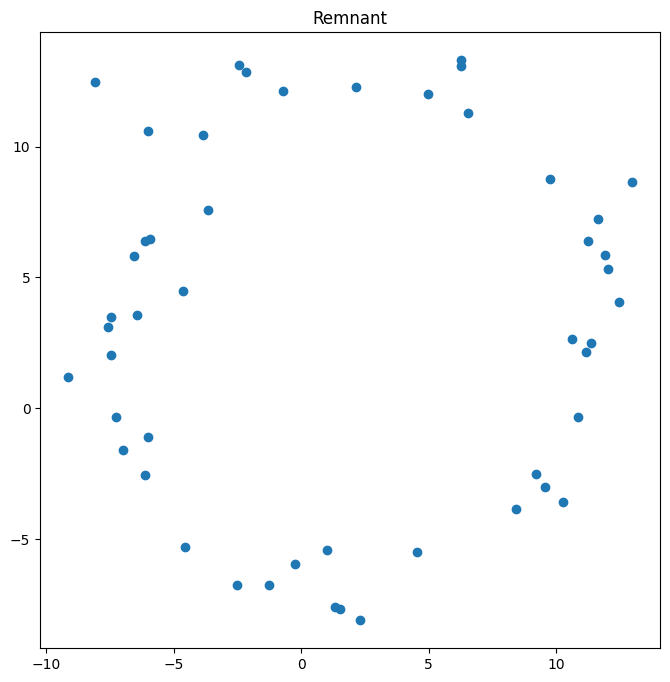

In [46]:
# Find the inliers of the best model
distances = np.abs(a * X[:, 0] + b * X[:, 1] - c)

# Subtract the inliers from the data
remnant_points = X[distances >= t]

# plot the remnant
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(remnant_points[:, 0], remnant_points[:, 1])
ax.set_title('Remnant')
plt.show()



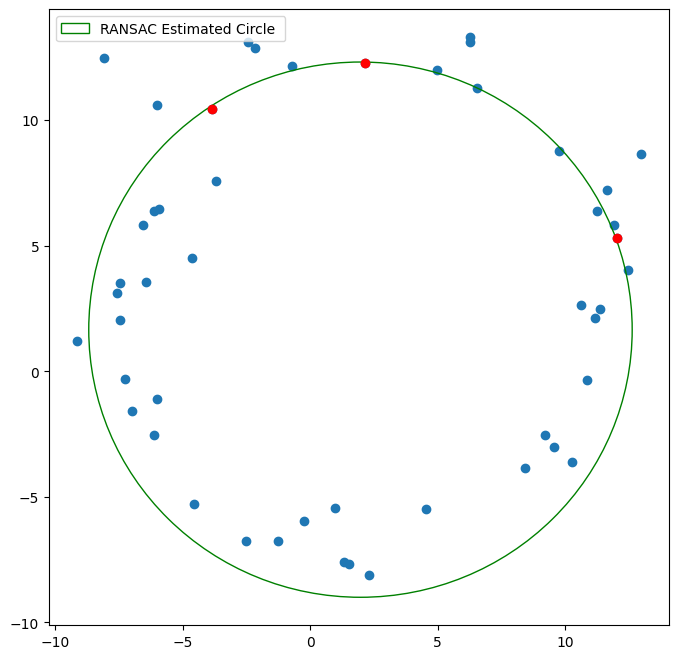

In [47]:
from scipy.optimize import minimize


# Parameters for Circle Estimation RANSAC
s = 3  # Number of points to sample for each circle hypothesis
t = 0.3 # Threshold of radial error
d = 30  # Minimum number of inliers to fit a circle
k = 10000# Number of RANSAC iterations

# Initialize variables to store the best circle model and inliers
best_circle_model = None
max_inlier_count = 0
best_inliers_c = None
S1_c, S2_c, S3_c = None, None, None

# Define the function to minimize
def circle_residuals(params, points):
    x0, y0, r = params
    # Calculate the residuals: distance between the points and the circle
    return np.sum((np.sqrt((points[:, 0] - x0) ** 2 + (points[:, 1] - y0) ** 2) - r) ** 2)

for i in range(k):
    # Randomly sample 's' points from the remnant dataset
    sample_indices = np.random.choice(remnant_points.shape[0], s, replace=False)
    s1 = remnant_points[sample_indices[0]]
    s2 = remnant_points[sample_indices[1]]
    s3 = remnant_points[sample_indices[2]]

    points = np.vstack((s1, s2, s3))

    # Fit a circle to the sampled points using least squares
    
    # Initial guess for center and radius
    initial_guess = [0, 0, 1]

    # Optimize using scipy.minimize
    result = minimize(circle_residuals, initial_guess, args=(points,))

    # Retrieve the optimized center and radius
    x0_opt, y0_opt, r_opt = result.x
    
    # Compute the inliers
    # Compute differens between the radius and the distances between all points and the circle center
    distances = np.abs(np.sqrt((remnant_points[:, 0] - x0_opt) ** 2 + (remnant_points[:, 1] - y0_opt) ** 2) - r_opt)

    # Compute the inliers count
    # find the set of inliers by checking if the distances are less than the threshold
    inliers = remnant_points[distances < t]

    # Compute the inliers count
    inlier_count = np.sum(inliers)

    # Check if the current set of inliers is the best one
    if inlier_count > max_inlier_count and inlier_count > d:
        max_inlier_count = inlier_count
        best_circle_model = (x0_opt, y0_opt, r_opt)
        best_inliers_c = inliers
        S1_c, S2_c, S3_c = s1, s2, s3

# Retrieve the best circle model
x0, y0, radius = best_circle_model

# Find the best circle using best_inliers with TLS
# Initial guess for center and radius
initial_guess = [0, 0, 1]

# Optimize using scipy.minimize
result = minimize(circle_residuals, initial_guess, args=(best_inliers_c,))

# Retrieve the optimized center and radius
x0_opt, y0_opt, r_opt = result.x

# Display the results
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Plot the remnant points
ax.scatter(remnant_points[:, 0], remnant_points[:, 1])


# Plot the best circle using minimum distance
circle = plt.Circle((x0_opt, y0_opt), r_opt, fill=False, color='g', label='RANSAC Estimated Circle ')
ax.add_patch(circle)

# Plot S1, S2, S3
ax.plot(S1_c[0], S1_c[1], 'ro')
ax.plot(S2_c[0], S2_c[1], 'ro')
ax.plot(S3_c[0], S3_c[1], 'ro')

plt.legend()
plt.show()




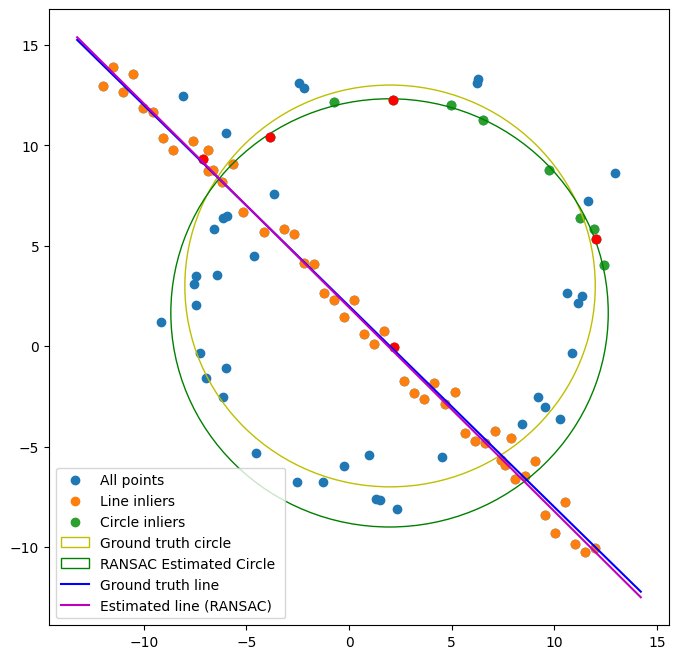

In [49]:
# Plot all in one figure
'''All points
Line inliers
Best sample for line
Circle inliers
Best sample for circle
Ground truth circle
RANSAC circle
Ground truth line
RANSAC line'''

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Plot all points
ax.scatter(X[:, 0], X[:, 1], label='All points')

# Plot the line inliers
ax.scatter(best_inliers_L[:, 0], best_inliers_L[:, 1], label='Line inliers')

# Plot the best sample for line
ax.plot(S1[0], S1[1], 'ro')
ax.plot(S2[0], S2[1], 'ro')

# Plot the circle inliers
ax.scatter(best_inliers_c[:, 0], best_inliers_c[:, 1], label='Circle inliers')

# Plot the best sample for circle
ax.plot(S1_c[0], S1_c[1], 'ro')
ax.plot(S2_c[0], S2_c[1], 'ro')
ax.plot(S3_c[0], S3_c[1], 'ro')

# Plot the ground truth circle
circle_gt = plt.Circle((x0_gt, y0_gt), r, color='y', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)

# Plot the RANSAC circle

circle1 = plt.Circle((x0_opt, y0_opt), r_opt, fill=False, color='g', label='RANSAC Estimated Circle ')
ax.add_patch(circle1)

# Plot the ground truth line
plt . plot ( x_g , y_g , color= 'b' , label= 'Ground truth line' )

# Plot the RANSAC line
plt.plot(x_g, y_tls, color='m', label='Estimated line (RANSAC)')

plt.legend()
plt.show()



Please select four points on Image1 for homography calculation.
Click on the bottom-left corner of the object and proceed anti-clockwise.
[[164. 199.]
 [373. 207.]
 [374.  74.]
 [162.  70.]]


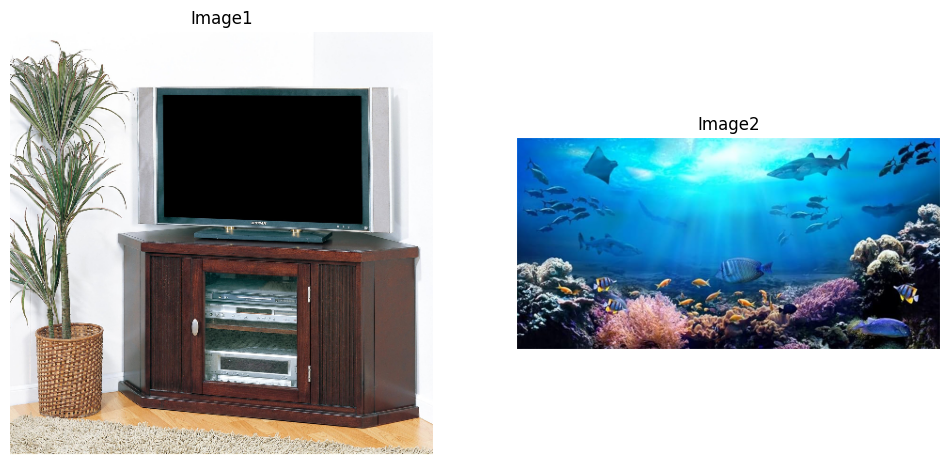

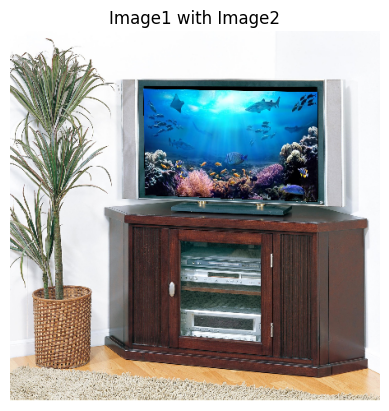

In [31]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to get the mouse click coordinates
def get_mouse_click(event, x, y, flags, param):
    global selected_points, current_point_index

    if event == cv2.EVENT_LBUTTONDOWN:
        selected_points[current_point_index] = (x, y)
        current_point_index += 1
        if current_point_index == 4:
            cv2.destroyAllWindows()

# Load the images
im1 = cv2.imread("tv.jpg")  
im2 = cv2.imread("ocean.jpg")  
# Define a resize factor to make image1 manageable for point selection
resize_factor = 0.25
im1_resized = cv2.resize(im1, None, fx=resize_factor, fy=resize_factor)

# Display the resized image1 using OpenCV for point selection
cv2.imshow('Image1', im1_resized)
cv2.setMouseCallback('Image1', get_mouse_click)

# Initialize variables for selected points
selected_points = [None] * 4
current_point_index = 0

# Wait for the user to select the four corner points by clicking on the resized Image1
print("Please select four points on Image1 for homography calculation.")
print("Click on the bottom-left corner of the object and proceed anti-clockwise.")
while current_point_index < 4:
    cv2.waitKey(1)

# Close the OpenCV window
cv2.destroyAllWindows()

# Display image2 using Matplotlib
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(im1_resized, cv2.COLOR_BGR2RGB))
plt.title("Image1")
plt.axis('off')  # Remove axis labels

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(im2, cv2.COLOR_BGR2RGB))
plt.title("Image2")
plt.axis('off')  # Remove axis labels

# Convert selected points to a NumPy array: order of points is [bottom_left, bottom_right, top_right, top_left]
selected_points = np.array(selected_points, dtype=np.float32)
print(selected_points)

if selected_points.shape == (4, 2):
    # Define the corner points of image2 # shape (445, 894, 3)
    # [bottom_left, bottom_right, top_right, top_left]
    pts1 = np.float32([[0, im2.shape[0]], [im2.shape[1], im2.shape[0]], [im2.shape[1], 0], [0, 0]])
                        

    # Create a transformation matrix to map image2 to image1
    h, _ = cv2.findHomography(pts1,selected_points)

    # Warp image2 to image1
    img2_warp = cv2.warpPerspective(im2, h, (im1_resized.shape[1], im1_resized.shape[0]))

    # Create a mask for the image2 region
    img2_mask = np.zeros_like(im1_resized, dtype=np.uint8)
    cv2.fillConvexPoly(img2_mask, selected_points.astype(int), (255, 255, 255))

    # Invert the mask to get the non-image2 region
    non_img2_mask = cv2.bitwise_not(img2_mask)

    # Remove the image2 region from image1
    img1_without_img2 = cv2.bitwise_and(im1_resized, non_img2_mask)

    # Combine the image2 region and the image1 without the image2 region
    result = cv2.bitwise_or(img2_warp, img1_without_img2)

    # Display the result
    plt.figure()
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.title("Image1 with Image2")
    plt.axis('off')  # Remove axis labels

    '''# Visualize the selected points on both images
    plt.plot(selected_points[:, 0], selected_points[:, 1], 'ro')  # Red circles for selected points on image1
    plt.plot(pts1[:, 0], pts1[:, 1], 'go')  # Green circles for corresponding points on image2

    # Draw lines connecting the selected points for visualization
    for i in range(4):
        plt.plot([selected_points[i, 0], pts1[i, 0]], [selected_points[i, 1], pts1[i, 1]], 'b-')'''

    plt.show()
else:
    print("Please select four points on Image1 for homography calculation.")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares


# Parameters for Circle Estimation RANSAC
s = 3  # Number of points to sample for each circle hypothesis
t = 0.1  # Threshold of radial error
d = 10  # Minimum number of inliers to fit a circle

# Initialize variables to store the best circle model and inliers
best_circle_model = None
max_inlier_count = 0
best_inliers = []

# Number of RANSAC iterations
k = 1000

for i in range(k):
    # Randomly sample 's' points from the remnant dataset
    sample_indices = np.random.choice(remnant_points.shape[0], s, replace=False)
    sampled_points = remnant_points[sample_indices]

    # Fit a circle to the sampled points using least squares
    def circle_residuals(params, points):
        x0, y0, r = params
        return np.sqrt((points[:, 0] - x0) ** 2 + (points[:, 1] - y0) ** 2) - r

    initial_guess = [0.0, 0.0, 1.0]  # Initial guess for circle parameters [x0, y0, radius]
    result = least_squares(circle_residuals, initial_guess, args=(sampled_points,))
    circle_params = result.x

    # Calculate the radial error for all points
    radial_errors = np.abs(np.sqrt((remnant_points[:, 0] - circle_params[0]) ** 2 + (remnant_points[:, 1] - circle_params[1]) ** 2) - circle_params[2])

    # Count the number of inliers
    inliers = np.where(radial_errors < t)[0]
    inlier_count = len(inliers)

    # Check if the current set of inliers is the best one
    if inlier_count > d and inlier_count > max_inlier_count:
        max_inlier_count = inlier_count
        best_circle_model = circle_params
        best_inliers = inliers

# Retrieve the best circle model
x0, y0, radius = best_circle_model

# Display the results
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Plot the remnant points
ax.scatter(remnant_points[:, 0], remnant_points[:, 1])

# Plot the best circle
circle = plt.Circle((x0, y0), radius, fill=False, color='m', label='Estimated Circle')
ax.add_patch(circle)

# Plot the inliers
inlier_points = remnant_points[best_inliers]
ax.scatter(inlier_points[:, 0], inlier_points[:, 1], color='r', marker='o', label='Inliers')

plt.legend()
plt.show()
